In [1]:
import gym
import numpy as np
import random
import torch
from itertools import count


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [3]:
class Memory():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.short_memory = []
        
    def push(self, old_state, action, reward, new_state, final):
        self.short_memory.append([old_state, action, reward, new_state, final])
        
    def commit(self, final=True): 
# #         discount
#         for i, memo in enumerate(self.short_memory[::-1]):
#             old_state, action, reward, new_state, *_ = memo
            
#             if i == 0:
#                 prev_reward = reward
#                 continue
                
#             reward, prev_reward = prev_reward * 0.99 + reward, reward
#             self.short_memory[len(self.short_memory) - 1 - i][2] = reward 
            
#         self.short_memory = [x for x in self.short_memory if x[-1] == False]
        
        if len(self.memory) + len(self.short_memory) < self.capacity:
            self.memory.extend(self.short_memory)
        else:
            for memo in self.short_memory:
                self.memory.insert(random.randint(0, len(self.memory) - 1), memo)
                
        self.memory = self.memory[:self.capacity]
        self.short_memory = []

In [10]:
class Qnet(torch.nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(4, 32),
#             torch.nn.LeakyReLU(inplace=True),
#             torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(32, 2),
#             torch.nn.Sigmoid(),
        #     torch.nn.Softmax(dim=1),
        )
    
    def forward(self, x):
        return self.model(x)

policy_net = Qnet().to(device)
target_net = Qnet().to(device)

target_net.load_state_dict(policy_net.state_dict())

optim = torch.optim.Adam(policy_net.parameters(), lr=0.03)
# optim = torch.optim.SGD(policy_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=100, gamma=0.84)    

In [49]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 2000

EPS = 0.9
EPS_MIN = 0.2
GAMMA = 0.9999


def get_model_action(model, state, device, train=True):
    global EPS, EPS_MIN, GAMMA
    EPS = EPS * GAMMA
    EPS = max(EPS, EPS_MIN)
    
    if not train or random.random() > EPS:
        with torch.no_grad():
            model_output = model(torch.FloatTensor(state).to(device).unsqueeze(0)).cpu().detach().numpy()
            action = np.argmax(model_output[0])
#             print(state, model_output, action)
            
    else:
        action = random.randint(0, 1)
    return action

def train(model, memory, device):
    memory = memory.memory
    try:
        memory = random.sample(memory, 128)
    except ValueError:
        return

    s0 = [x[0] for x in memory]
    a = [x[1] for x in memory]
    r = [x[2] for x in memory]
    s1 = [x[3] for x in memory]
    done = [1. if x[4] else 0. for x in memory]


    s0 = torch.FloatTensor(s0).to(device)
    s1 = torch.FloatTensor(s1).to(device)
    a = torch.LongTensor(a).to(device)
    r = torch.FloatTensor(r).to(device)
    done = torch.FloatTensor(done).to(device)

    q_values = policy_net(s0)
    next_q_values = target_net(s1)
    next_q_value = next_q_values.max(1)[0]

    q_value = q_values.gather(1, a.unsqueeze(1)).squeeze(1)
    expected_q_value = r + 0.999 * next_q_value * (1.0 - done)
    # Notice that detach the expected_q_value
    loss = (expected_q_value.detach() - q_value).pow(2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

        
#     scheduler.step()

memory = Memory(capacity=100000)  
len_mem = []

try:
    for episode in range(100000):
        state = env.reset()

        for i in count():
#             env.render()

            action = get_model_action(policy_net, state, device)
            old_state = state
            state, reward, done, info = env.step(action)

            if done:
                env.close()
                len_mem.append(i)
                
                if abs(i-2000) < 10:
                    reward = 1
                    final = False
                else:
                    reward = -5
                    final = True
                
                memory.push(old_state, action, reward, state, final)
                memory.commit()
                break
            else:
                memory.push(old_state, action, reward, state, False)

        
        if episode % 100 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, np.mean(len_mem[-50:]), EPS))
        
        train(policy_net, memory, device)
        
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
    
except KeyboardInterrupt:
    env.close()

Episode   0:     14.000 iterations, eps=0.898651
Episode 100:     54.660 iterations, eps=0.571333
Episode 200:   1282.780 iterations, eps=0.200000
Episode 300:   1415.260 iterations, eps=0.200000
Episode 400:   1306.320 iterations, eps=0.200000
Episode 500:   1381.200 iterations, eps=0.200000
Episode 600:   1198.700 iterations, eps=0.200000
Episode 700:   1244.000 iterations, eps=0.200000


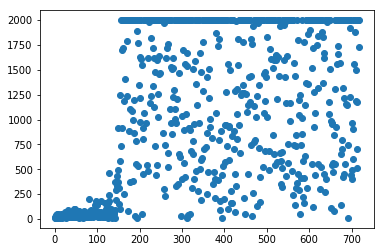

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure()
plt.plot(len_mem, 'o')

In [ ]:
try:
    env.seed = random.randint(0, 100000)
    obs = env.reset()
    env._max_episode_steps = 100000
    for t in count():
        
        if t % 500 == 0:
            print(t)
        
        env.render()
        global EPS
        EPS = 0.0
        action = get_model_action(policy_net, obs, device, train=True)
        obs, reward, done, info = env.step(action)
        if done:
            env.close()
            break

    print(t)
except KeyboardInterrupt:
    pass
finally:
    env.close()
    print (t)

0
500
1000


In [12]:
model = policy_net

In [13]:
model.to('cpu')

Qnet(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [14]:
torch.save(model, 'model.torch')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [26]:
model = torch.load('model.torch')

In [27]:
model.to(device)

Qnet(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [28]:
policy_net = model